Nosso objetivo é determinar a constante de Hubble usando o método de Markov Chain Monte Carlo (MCMC). A técnica de MCMC é muito útil para determinar parâmetros desconhecidos, a partir de uma distribuição de probabilidades inicial, que é ajustada com base em dados observados. Por ser uma técnica baseada na estatística Bayesiana, é fácil incorporar conhecimentos que temos, a priori, a respeito do modelo ou dos parâmetros que desejamos determinar. Mesmo uma grande quantidade de parâmetros indeterminados pode ser ajustado, dado que tenhamos observações ou informações o suficiente a respeito do problema, mas mesmo com informações iniciais escassas, ainda podemos tirar conclusões valiosas e realizar ajustes razoáveis.

# A Ideia Básica do Markov Chain Monte Carlo

Quando nos deparamos com um problema Bayesiano com N incógnitas, temos implicitamente um espaço N dimensional para as distribuições a priori e, associado a esse espaço, temos uma superfície que reflete a probabilidade a priori para um ponto particular. Essa superfície é definida pelas distribuições a priori que escolhemos.

Por exemplo, caso tenhamos duas incógnitas, $a$ e $b$, e assumimos uma distribuição inicial dada pela distribuição Uniforme, de 0 a 5, então a nossa superfície é dada por:

In [1]:
from IPython.core.pylabtools import figsize
from mpl_toolkits.mplot3d import Axes3D
from scipy import constants, stats
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
import pymc3 as pm
import numpy as np
import arviz as az
import scipy

sns.set_style('darkgrid')
figsize(12.5, 4)

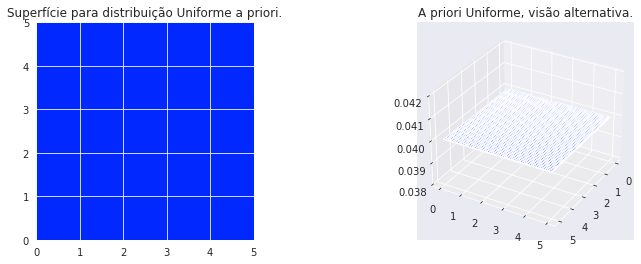

In [2]:
jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície para distribuição Uniforme a priori.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("A priori Uniforme, visão alternativa.");

O problema é que esse espaço ilustrado é 2D, para apenas dois parâmetros, mas na prática, eles podem ser de dimensões superiores, impossíveis de se visualizar.

Mas e se quisermos incorporar dados observados, o que acontece com essas distribuições a priori e com as incógnitas? Os dados não interferem no espaço, mas mudam a superfície a priori para que ela reflita qual a localização mais provável dos parâmetros. Quanto mais dados, mais a superfície a priori é distorcida, e mais a função que usamos inicialmente para o ajuste dos parâmetros se torna irrelevante comparada a superfície determinada pelos dados observados. Essa superfície resultante é a superfície que descreve a distribuição a posteriori.

Supondo, por exemplo, que as duas incógnitas anteriormente citadas representam diferentes parâmetros $\lambda$ de duas distribuições de Poisson, podemos observar como a inserção de dados molda a superfície da distribuição dada a priori:

In [3]:
# Criamos os dados observados:
N = 1 # O número de amostras.

# Os valores verdadeiros dos parâmetros, que não sabemos.
lambda_1_true = 1
lambda_2_true = 3

# Geramos dados aleatórios de Poisson, baseados nesses parâmetros.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)

# Localização deles na superfície:
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x) for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y) for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

(0.0, 5.0)

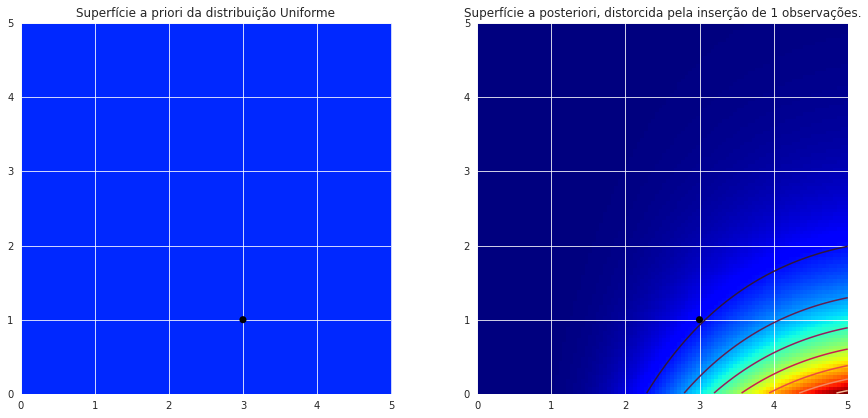

In [4]:
figsize(15, 15)

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície a priori da distribuição Uniforme")

plt.subplot(222)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Superfície a posteriori, distorcida pela inserção de 1 observações.")
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

A região em vermelho é onde há a maior probabilidade. Na distribuição a priori, a superfície está toda da mesma cor pois para a distribuição Uniforme, todos os pontos são igualmente prováveis.

Mas atravessar um espaço com N dimensões seria impraticável, pois a demanda computacional cresce exponencialmente com N. Assim, o MCMC faz uma busca inteligente nesse espaço de probabilidades, retornando amostras aleatórias da distribuição a posteriori e, após amostragens o suficiente, vai convergindo cada vez mais para as áreas de maior probabilidade a posteriori.

O algoritmo começa de um ponto inicial na superfície a posteriori (que tem formato desconhecido) e faz amostragens de valores próximos de sua localização atual nessa superfície, determinando em qual direção a probabilidade posterior aumenta, e assim, na próxima amostragem, parte desse ponto de maior probabilidade e vai para o próximo, eventualmente convergindo até as regiões de maior probabilidade. Ao fim disso, ele converge para a distribuição a posteriori.

# A Determinação da Constante de Hubble

In [5]:
input25 = np.loadtxt('data/cf3-25mpc.txt', skiprows=1)
dist25 = input25[:,0]
erro25 = input25[:,1]
redshift25 = input25[:,2]

input50 = np.loadtxt('data/cf3-50mpc.txt', skiprows=1)
dist50 = input50[:,0]
erro50 = input50[:,1]
redshift50 = input50[:,2]

input500 = np.loadtxt('data/cf3.txt', skiprows=1)
dist500 = input500[:,0]
erro500 = input500[:,1]
redshift500 = input500[:,2]

input_filt = np.loadtxt('data/cf3_filt.txt', skiprows=1)
dist_filt = input_filt[:,0]
redshift_filt = input_filt[:,1]
erro_redshift_filt = input_filt[:,2]

#plt.figure(figsize=[10, 7])
#plt.scatter(dist_filt, redshift_filt)
#plt.ylabel('Redshift')
#plt.xlabel('Distâncias (Mpc)')

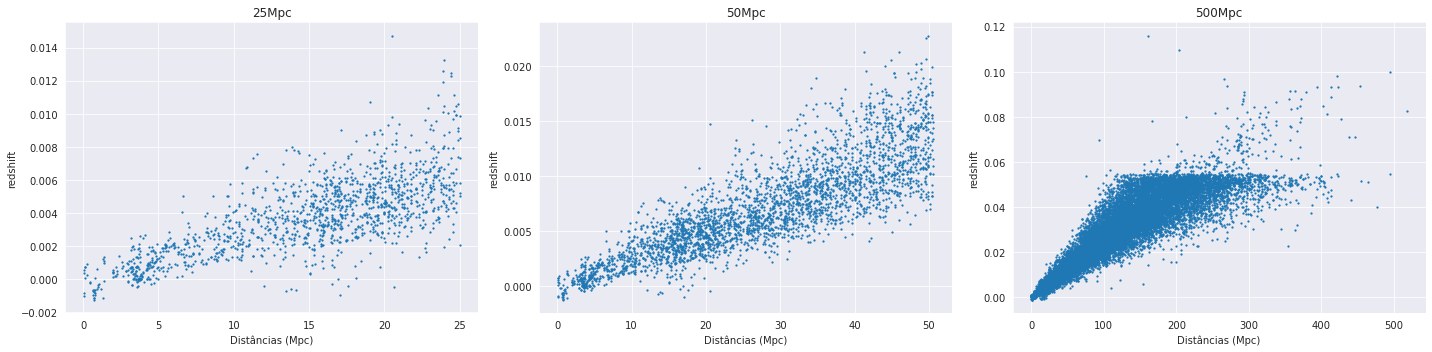

In [6]:
mapas = ['data/cf3-25mpc.txt', 'data/cf3-50mpc.txt', 'data/cf3.txt', 'data/cf3_filt.txt']
title = ['25Mpc', '50Mpc', '500Mpc', 'filt']
plt.figure(figsize=[20, 5])

for i in range (3):
    input = np.loadtxt(mapas[i], skiprows=1)
    dist = input[:,0]
    erro = input[:,1]
    redshift = input[:,2]
    plt.tight_layout()
    plt.subplot(1, 3, i+1)
    plt.scatter(dist, redshift, s=1.5)
    plt.title(title[i])
    plt.ylabel('redshift')
    plt.xlabel('Distâncias (Mpc)')
    
plt.show()

Como dito inicialmente, o nosso objetivo é determinar a constante de Hubble usando o método de Markov Chain Monte Carlo. Para isso, precisamos supor um modelo inicial para os nosso parâmetros (a distribuição a priori, mencionada anteriormente) a fim de que, através das amostragens aleatórias, sejam ajustados aos valores mais prováveis.

Vamos começar pela Lei de Hubble pura, isto é, a Lei de Hubble apenas com os termos de primeira ordem, que fica com a seguinte forma:

$$r = H_0 . \frac{d}{c} \; ,$$

em que $r$ é o redshift, $H_0$ a constante de Hubble, $d$ a distância (em Mpc), e $c = 299792 \; m/s$ é a velocidade da luz.

Como estamos lidando com um modelo Bayesiano, precisamos determinar uma distribuição a priori para as variáveis desconhecidas (no caso, $H_0$), que será ajustada ao valor mais provável, em função dos dados observados. Assim, para simular um cenário no qual não temos uma medida muito precisa da constante de Hubble, vamos assumir que o parâmetro que nos retornará o valor de $H_0$ será ajustado por uma distribuição Normal, com valor médio $\mu_{h0} = 70$, e desvio-padrão $\sigma_{h0} = 10$:

In [7]:
import pymc3 as pm

with pm.Model() as hubble_model:
    # Priors para os nossos parâmetros desconhecidos:
    h0 = pm.Normal('h0_only', mu=70, sigma=10, testval=70)
    
    # Valor esperado do resultado:
    redshift_m = h0 * dist50 / 299792
    
    # Likelihood (distribuição da amostragem) das observações:
    redshift_obs = pm.Normal('obs', mu=redshift_m, sigma=np.mean(erro50), observed=redshift50)
    
    # O algoritmo que usamos para fazer o sampling é o Metropolis-Hastings:
    step = pm.Metropolis()
    trace = pm.sample(100000, tune=10000, step=step, return_inferencedata=False)
    burned_trace_h0 = trace[50000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [h0_only]


Sampling 4 chains for 10_000 tune and 100_000 draw iterations (40_000 + 400_000 draws total) took 42 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/antoniofreire/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


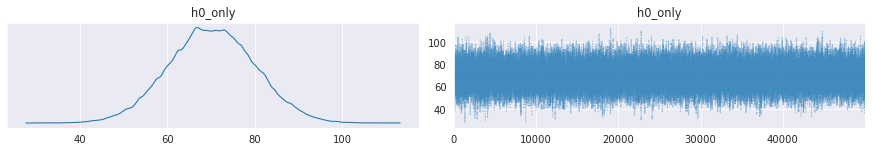

In [8]:
az.plot_trace(burned_trace_h0, combined=True);

Esses gráficos acima descrevem a distribuição dos valores determinados para a constante de Hubble ao longo das 100000 iterações. Podemos perceber, por exemplo, que o valor de $H_0$ converge para próximo de 70, o que podemos verificar pela média dos valores gerados:

In [9]:
h0_only_samples = burned_trace_h0['h0_only']
h0_only_mean = np.mean(h0_only_samples)

print(r"O valor médio de $H_0$ é: ", h0_only_mean)

O valor médio de $H_0$ é:  70.09417977248211


Outra característica que visualizamos é que os valores parecem 'caminhar aleatoriamente' no espaço, isto é, o caminho parece mostrar uma correlação entre as posições anteriores e as posteriores. Isso é uma característica de Cadeias de Markov, e permite que a função tenha sua convergência para um certo valor (apesar que, caso precisemos explorar muito bem o espaço, essa correlação não pode ser muito forte).

Podemos visualizar melhor a distribuição desses dados pelos histogramas abaixo. No primeiro, acima, a linha preta vertical representa a localização do valor médio encontrado. No segundo histograma, abaixo do primeiro, a linha preta horizontal ilustra o intervalo de confiança de 94% (o valor de $H_0$ está entre 52 e 89 com 94% de confiança):

/home/antoniofreire/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'x'}>

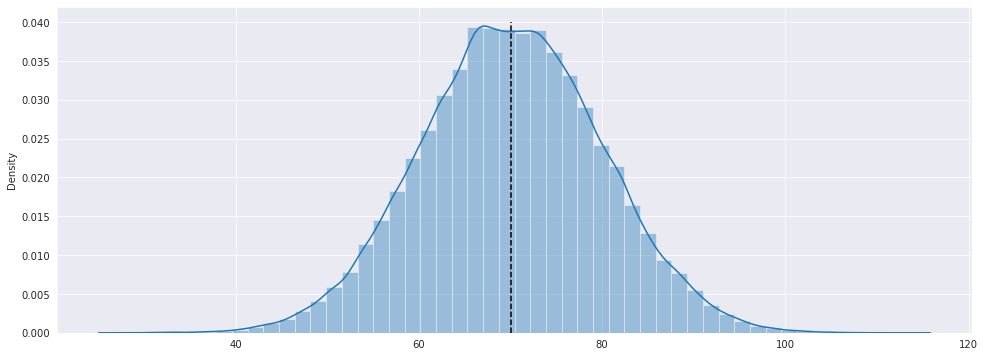

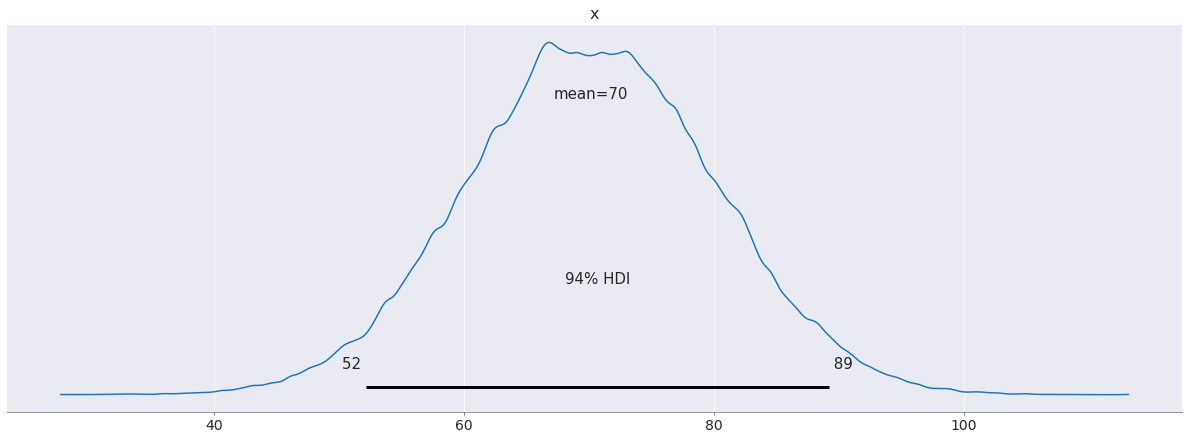

In [10]:
figsize(16.4, 6)

sns.distplot(h0_only_samples)
plt.vlines(h0_only_mean, 0, 0.04, linestyle='--', color='k', label='Valor médio de H_0')

pm.plot_posterior(h0_only_samples)

Podemos ainda demonstrar a robustez do método MCMC ao adicionar mais um parâmetro a ser determinado, o coeficiente linear, considerando um ajuste mais generalizado do que o anterior:

$$r = H_0 . \frac{d}{c} + \alpha \; ,$$

que o algoritmo deve determinar como tendo valor próximo a zero, demonstrando como ele é capaz de determinar múltiplas constantes simultaneamente. Novamente, assumirremos que o parâmetro que nos retornará o valor de $H_0$ será ajustado por uma Gaussiana com média $\mu_{h0} = 70$ e desvio-padrão $\sigma_{h0} = 10$, e para o coeficiente linear, teremos também uma Normal, com $\mu_{\alpha} = 0$ e $\sigma_{\alpha} = 10$:

In [11]:
import pymc3 as pm

with pm.Model() as hubble_model:
    # Priors para os nossos parâmetros desconhecidos:
    alpha = pm.Normal('alpha', mu=0, sigma=10, testval=0)
    h0 = pm.Normal('h0', mu=70, sigma=10, testval=70)
    
    # Valor esperado do resultado:
    redshift_m = alpha + h0 * dist50 / 299792
    
    # Likelihood (distribuição da amostragem) das observações:
    redshift_obs = pm.Normal('obs', mu=redshift_m, sigma=np.mean(erro50), observed=redshift50)
    
    # O algoritmo que usamos para fazer o sampling é o Metropolis-Hastings:
    step = pm.Metropolis()
    trace = pm.sample(100000, tune=10000, step=step, return_inferencedata=False)
    burned_trace = trace[50000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [h0]
>Metropolis: [alpha]


Sampling 4 chains for 10_000 tune and 100_000 draw iterations (40_000 + 400_000 draws total) took 61 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/antoniofreire/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


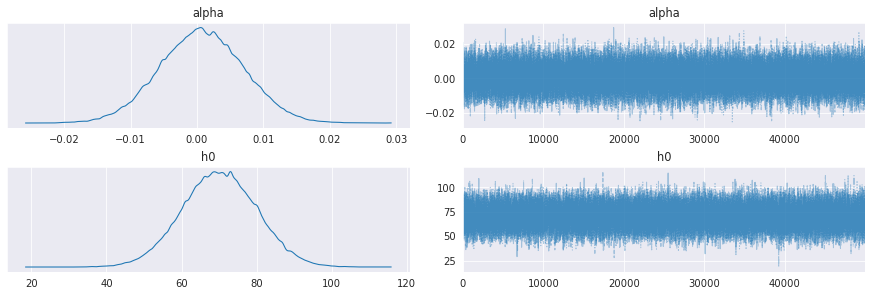

In [12]:
az.plot_trace(burned_trace, combined=True);

Pudemos observar aqui como ambos os parâmetros convergiram para determinados valores. O valor de $H_0$ parece ter convergido para um valor próximo de 70, novamente, e também o $\alpha$ parece ter ficado próximo de zero, como era esperado.

Podemos conferir os valores médios de ambos os parâmetros e perceber como, de fato, ambos convergiram com sucesso para valores próximos do esperado:

In [13]:
alpha_samples = burned_trace['alpha']
h0_samples = burned_trace['h0']

alpha_mean = np.mean(alpha_samples)
h0_mean = np.mean(h0_samples)

In [14]:
print('O valor médio das variáveis é: \n')
print('alpha =', alpha_mean)
print('H_0 =', h0_mean)

O valor médio das variáveis é: 

alpha = 0.0006614333701582288
H_0 = 70.01068606640774


É possível criar outro histograma com os valores de cada parâmetro, e observar novamente como a maioria dos valores determinados pelo algoritmo ficou em torno do esperado:

Text(0, 0.5, 'probability')

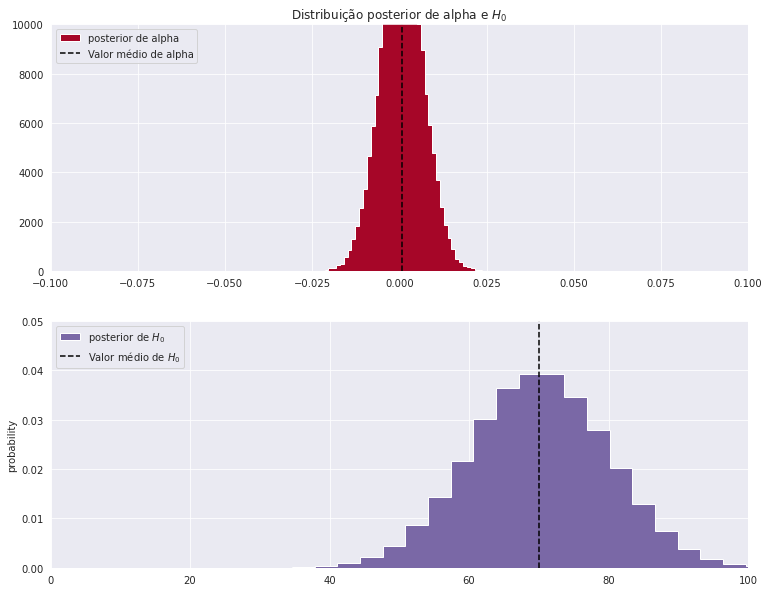

In [22]:
figsize(12.5, 10)
c = ["#A60628", "#7A68A6", "#467821"]

ax = plt.subplot(211)
ax.set_autoscaley_on(False)
plt.hist(alpha_samples, histtype='stepfilled', bins=50, label="posterior de alpha", color=c[0])
plt.vlines(alpha_mean, 0, 10000, linestyle='--', color='k', label='Valor médio de alpha')
plt.legend(loc="upper left")
plt.title(r"""Distribuição posterior de alpha e $H_0$""")
plt.xlim([-0.1, +0.1])
plt.ylim([0, 10000])

ax = plt.subplot(212)
ax.set_autoscaley_on(False)
plt.hist(h0_samples, histtype='stepfilled', bins=30, label="posterior de $H_0$", color=c[1], density=True)
plt.vlines(h0_mean, 0, 100, linestyle='--', color='k', label='Valor médio de $H_0$')
plt.legend(loc="upper left")
plt.xlim([0, 100])
plt.ylim([0, 0.05])

plt.legend(loc="upper left")
plt.ylabel("probability")

Agora, vamos usar os valores dos parâmetros que determinamos para verificar o quão bem eles se ajustam aos dados que fornecemos para o algoritmo. Abaixo, mostramos os dados empregados no MCMC, e em vermelho e laranja as retas dadas pelos parâmetros que determinamos (a reta laranjada é com o valor de $H_0$ determinado sem a adição de $\alpha$):

Text(0, 0.5, 'redshift')

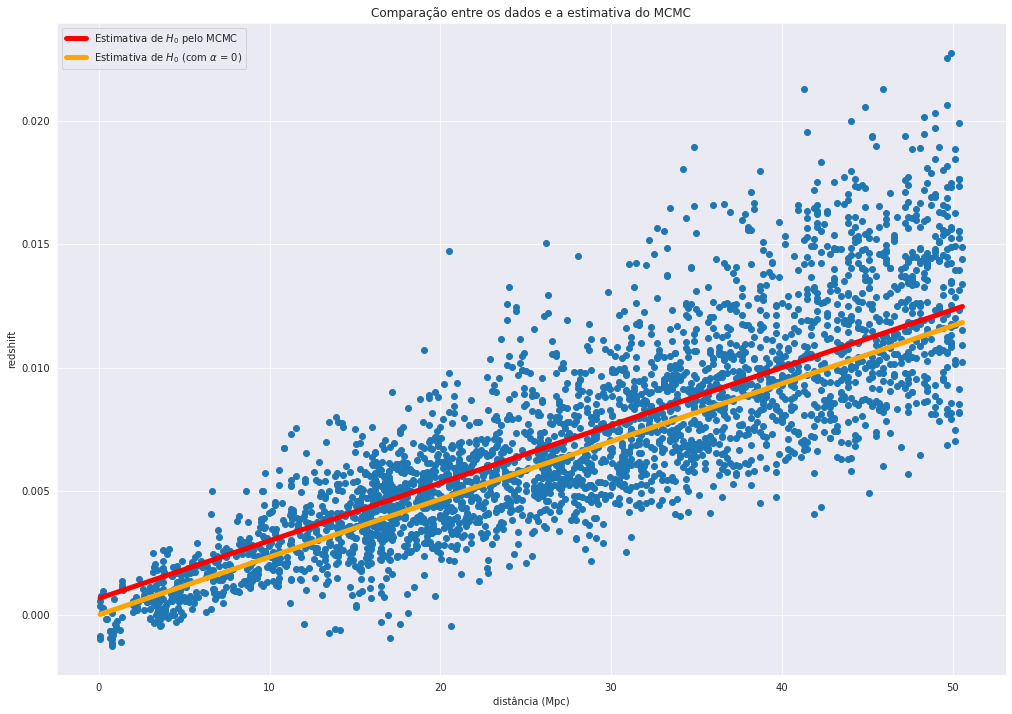

In [16]:
figsize(17, 12)
plt.title(r"""Comparação entre os dados e a estimativa do MCMC""")

plt.plot(dist50, h0_mean * dist50 / 299792 + alpha_mean, label='Estimativa de $H_0$ pelo MCMC', lw=5., c='red')
plt.plot(dist50, h0_only_mean * dist50 / 299792, label=r"Estimativa de $H_0$ (com $\alpha$ = 0)", lw=5., c='orange')

plt.scatter(dist50, redshift50)
plt.legend(loc="upper left")
plt.xlabel("distância (Mpc)")
plt.ylabel("redshift")

Podemos, também, exibir as estimativas de $H_0$ obtidas por MCMC, traçando a região com 68% e com 95% de confiança da estimativa dos parâmetros. Como a função que escolhemos para o ajuste do $H_0$ é a Normal, basta pegar os valores com 1 sigma e 2 sigma, respectivamente, ao redor da média, e criar o gráfico destacando estes intervalos:

In [17]:
h0_only_1sigma = [h0 for h0 in h0_only_samples if h0_only_mean - np.std(h0_only_samples) < h0 < h0_only_mean + np.std(h0_only_samples)]
h0_only_2sigma = [h0 for h0 in h0_only_samples if h0_only_mean - 2 * np.std(h0_only_samples) < h0 < h0_only_mean + 2 * np.std(h0_only_samples)]
h0_only_3sigma = [h0 for h0 in h0_only_samples if h0_only_mean - 3 * np.std(h0_only_samples) < h0 < h0_only_mean + 3 * np.std(h0_only_samples)]

Text(0, 0.5, 'redshift')

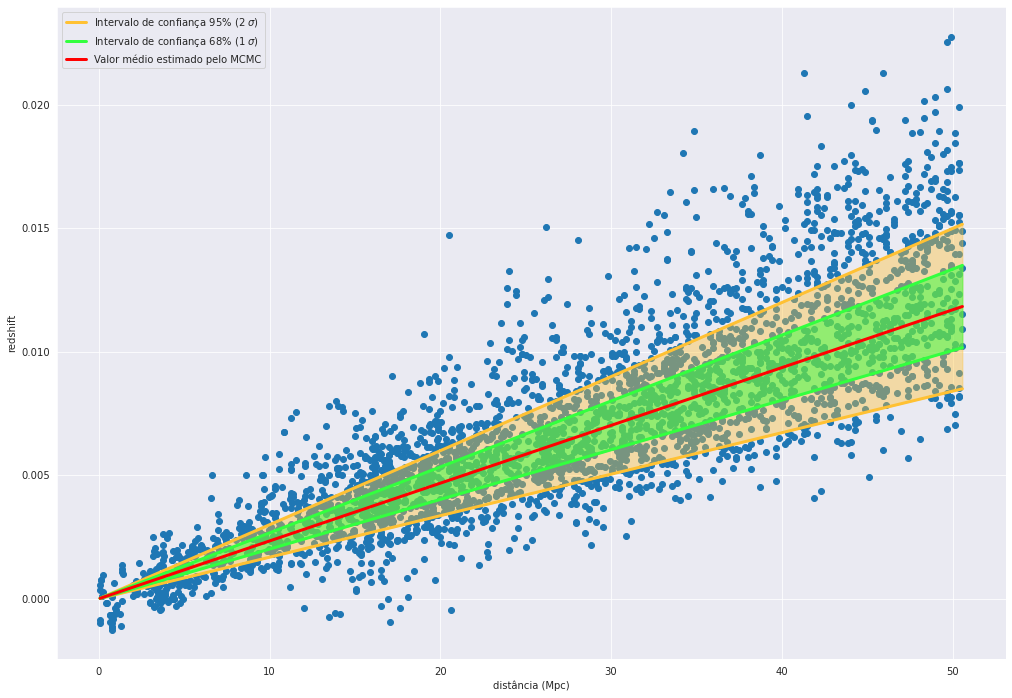

In [18]:
plt.scatter(dist50, redshift50)

plt.plot(dist50, np.min(h0_only_2sigma) * dist50 / 299792, lw=3., color='#ffc133')
plt.plot(dist50, np.max(h0_only_2sigma) * dist50 / 299792, label='Intervalo de confiança 95% (2 $\sigma$)', lw=3., color='#ffc133')

plt.fill_between(dist50, np.min(h0_only_2sigma) * dist50 / 299792, np.max(h0_only_2sigma) * dist50 / 299792, alpha=0.4, color='#ffc133')

plt.plot(dist50, np.min(h0_only_1sigma) * dist50 / 299792, lw=3., color='#33ff3f')
plt.plot(dist50, np.max(h0_only_1sigma) * dist50 / 299792, label='Intervalo de confiança 68% (1 $\sigma$)', lw=3., color='#33ff3f')

plt.fill_between(dist50, np.min(h0_only_1sigma) * dist50 / 299792, np.max(h0_only_1sigma) * dist50 / 299792, alpha=0.5, color='#33ff3f')

plt.plot(dist50, h0_only_mean * dist50 / 299792, label='Valor médio estimado pelo MCMC', lw=3., c='red')

plt.legend(loc="upper left")
plt.xlabel("distância (Mpc)")
plt.ylabel("redshift")

Por fim, é possível traçar várias retas diferentes, cada uma com um desses valores estimados de $H_0$, para visualizar como os valores estimados de $H_0$ (para diferentes posteriores) se ajustam aos dados:

Text(0, 0.5, 'redshift')

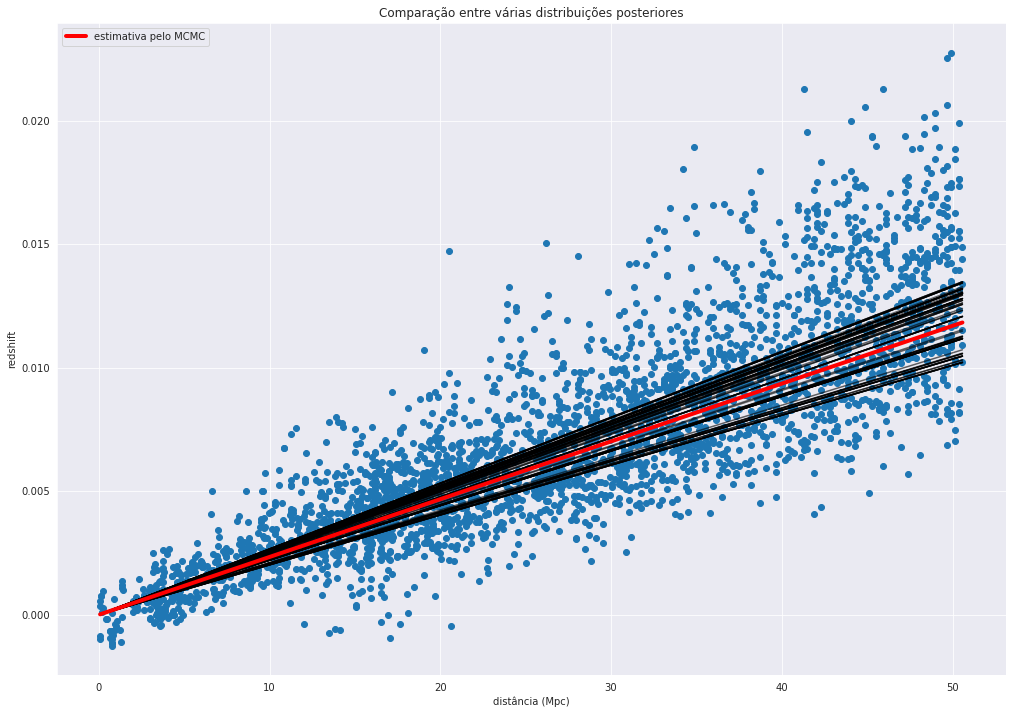

In [19]:
figsize(17, 12)

for h0 in(h0_only_1sigma[-100:]):
    plt.plot(dist50, h0 * dist50 / 299792, c='black', alpha=0.6)

plt.title(r"""Comparação entre várias distribuições posteriores""")

plt.plot(dist50, h0_only_mean * dist50 / 299792, label='estimativa pelo MCMC', lw=4., c='red')
plt.scatter(dist50, redshift50)
plt.legend(loc="upper left")
plt.xlabel("distância (Mpc)")
plt.ylabel("redshift")